# GAN Monet Challenge

## Brief Description of The Problem and Data

This project is part of the Kaggle competition "GAN Getting Started", which involves generating high-quality images using Generative Adversarial Networks(GANs). The challenge focuses on understanding the process of using GANs for image generation tasks, specifically creating artistic images inspired by Monet's paintings.

GANs are a type of deep learning model consisting of two neural networks: a generator and a discriminator. The generator creates fake images, while the discriminator attempts to distinguish between real and fake images. Through iterative training, the generator improves its ability to create realistic images, while the discriminator sharpens its classification accuracy.

Here is the link for competition: https://www.kaggle.com/competitions/gan-getting-started/overview

The dataset includes:

300 Monet paintings (monet_jpg)
7,028 photos (photo_jpg)
Each image is 256x256 pixels in size, and the challenge requires generating a large set of fake images that emulate Monet’s style. The goal is to produce between 7,000 to 10,000 high-quality images using the GAN model.

In [1]:
# Libraries

import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import tensorflow as tf
import re
from tensorflow.python.keras import layers, Model
adam = tf.keras.optimizers.Adam
import time
from IPython import display

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

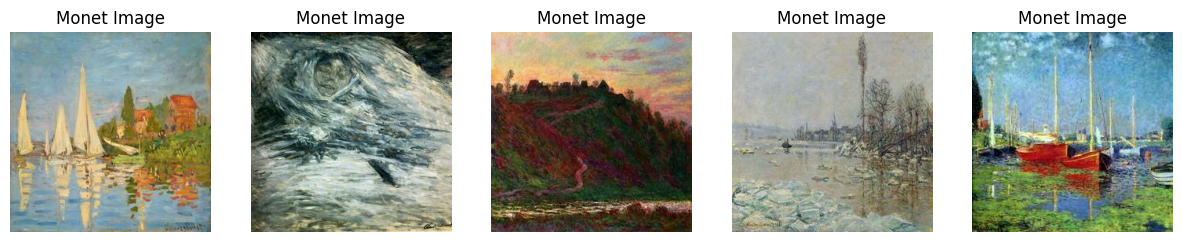

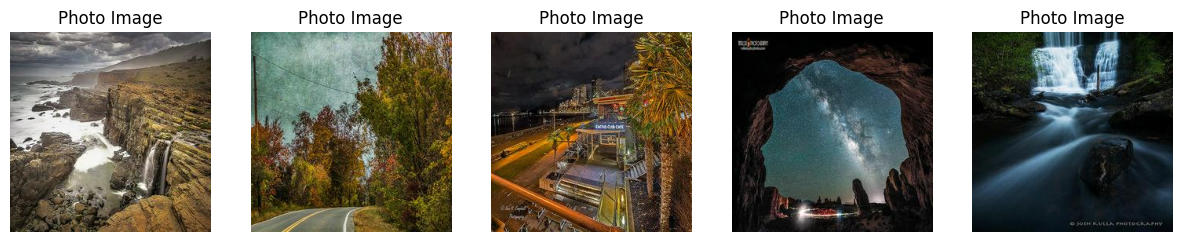

In [2]:
monet_path = Path('./data/monet_jpg')
photo_path = Path('./data/photo_jpg')

def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f'{title}')
        plt.axis('off')
    plt.show()

sample_monet_images = list(monet_path.glob('*.jpg'))[:5]
sample_photo_images = list(photo_path.glob('*.jpg'))[:5]

display_images(sample_monet_images, "Monet Image")
display_images(sample_photo_images, "Photo Image")

Coming from non-art background, in my eyes Monet photos look like art and stylish while other photos have more vivid colors.
Let's analyza the color distribution of images.

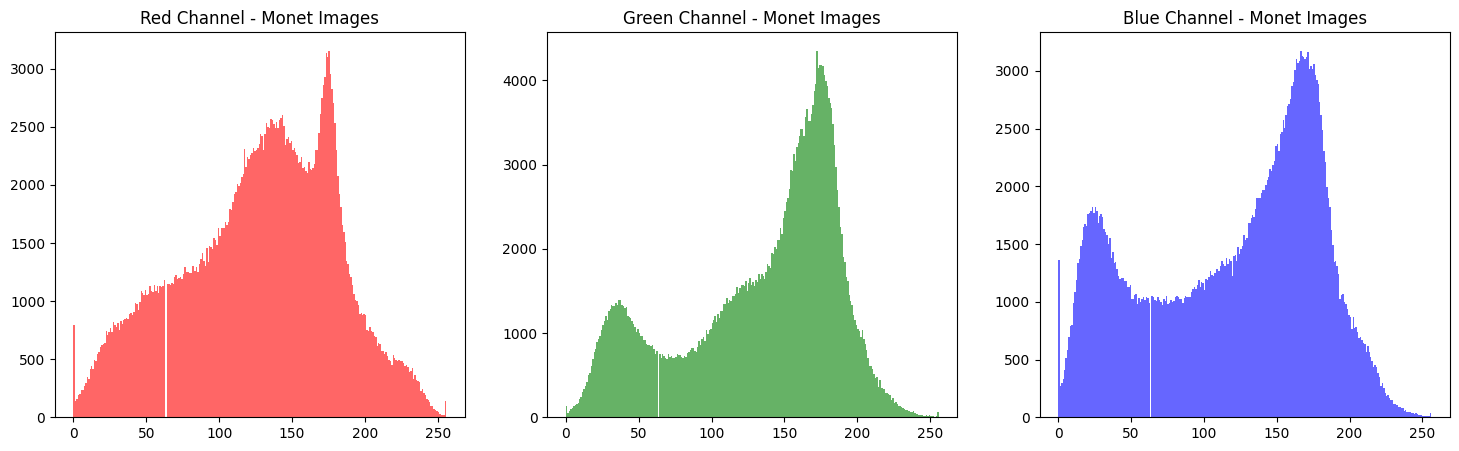

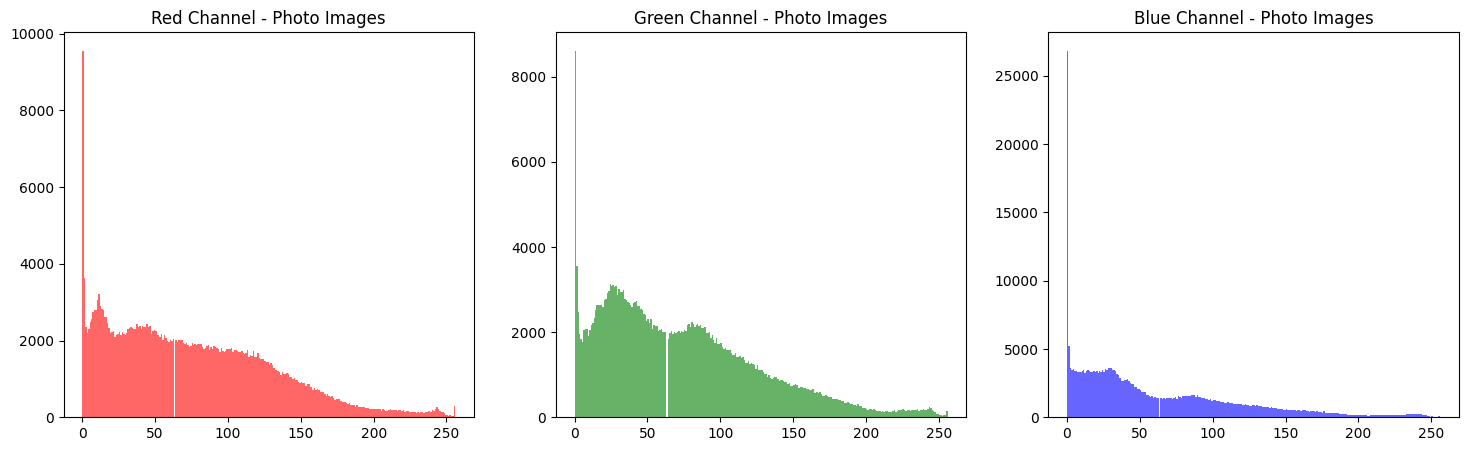

In [ ]:
def calculate_rgb_distribution(images):
    red_values = []
    green_values = []
    blue_values = []

    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
            red_values.extend(((img[:, :, 0] + 1) * 127.5).flatten())
            green_values.extend(((img[:, :, 1] + 1) * 127.5).flatten())
            blue_values.extend(((img[:, :, 2] + 1) * 127.5).flatten())
        else:
            raise ValueError("Image is not in the correct RGB format")
    return red_values, green_values, blue_values

def plot_rgb_distribution(red, green, blue, title):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.hist(red, bins=256, color='red', alpha=0.6, range=(0, 256))
    plt.title(f'Red Channel - {title}')

    plt.subplot(1, 3, 2)
    plt.hist(green, bins=256, color='green', alpha=0.6, range=(0, 256))
    plt.title(f'Green Channel - {title}')

    plt.subplot(1, 3, 3)
    plt.hist(blue, bins=256, color='blue', alpha=0.6, range=(0, 256))
    plt.title(f'Blue Channel - {title}')

    plt.show()

# Load images from file paths
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(str(path))  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = img.astype(np.float32) / 127.5 - 1  # Normalize to [-1, 1]
        images.append(img)
    return images

monet_image_paths = list(Path("./data/monet_jpg").glob("*.jpg"))[:5]
photo_image_paths = list(Path("./data/photo_jpg").glob("*.jpg"))[:5]

monet_images_analysis = load_images(monet_image_paths)
photo_images_analysis = load_images(photo_image_paths)

# Calculate RGB distributions for both datasets
red_A, green_A, blue_A = calculate_rgb_distribution(monet_images_analysis)
red_B, green_B, blue_B = calculate_rgb_distribution(photo_images_analysis)

# Plot RGB distributions
plot_rgb_distribution(red_A, green_A, blue_A, 'Monet Images')
plot_rgb_distribution(red_B, green_B, blue_B, 'Photo Images')


As histogram shows, Monet images have more intense use of 3 colors and have more dramatic peaks, while photo images are generally well balanced. 
Now I will proprocess the images in order to be used to build the model in next step.

<!-- ## Model Architecture

CycleGAN will be used, but before preprocessing needs to be done. -->

In [9]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalise
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image

# read TFRecord
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# augment
def data_augment(image):
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

MONET_FILENAMES = tf.io.gfile.glob(str('./data/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('./data/photo_tfrec/*.tfrec'))

monet_ds = load_dataset(MONET_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


Displaying Monet images:


2024-11-30 23:29:10.374358: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-11-30 23:29:10.406722: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


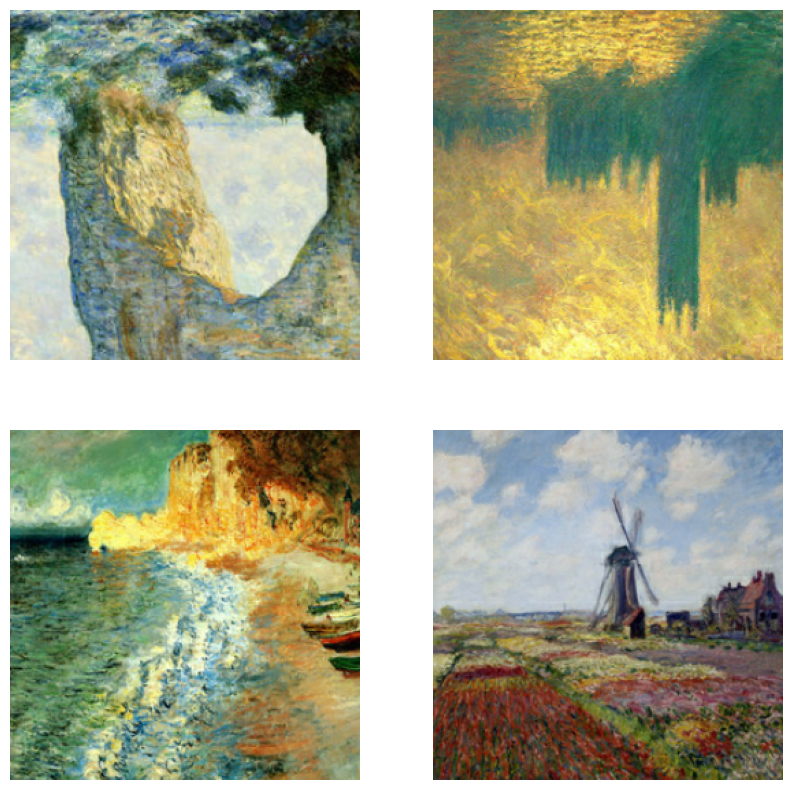

Displaying Photo images:


2024-11-30 23:29:10.776783: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


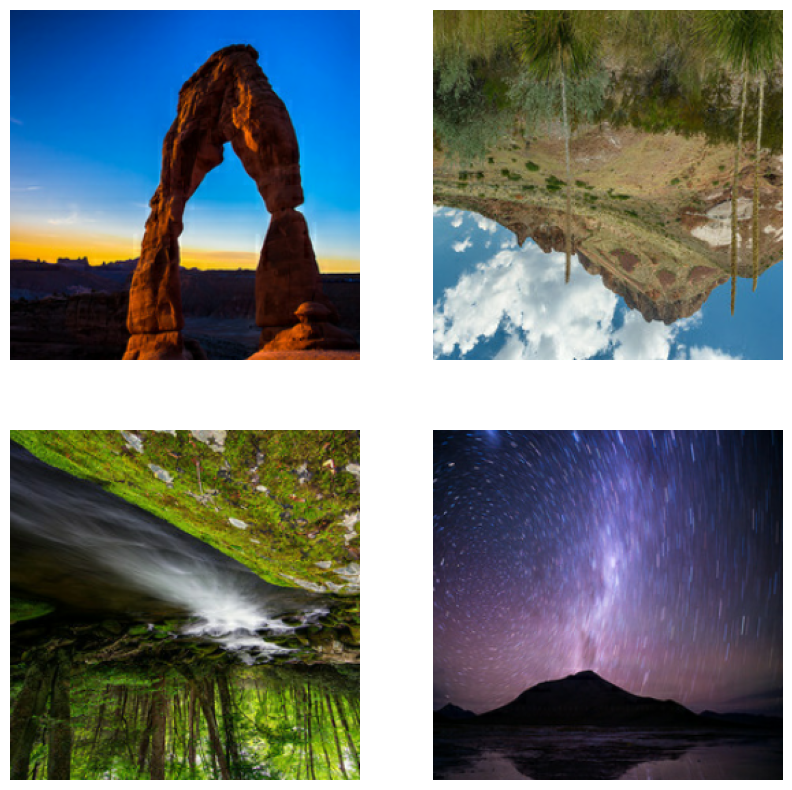

In [10]:
# check that it works 

def show_batch(dataset):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):
        for i in range(BATCH_SIZE):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow((images[i].numpy() + 1) / 2)
            plt.axis("off")
    plt.show()

print("Displaying Monet images:")
show_batch(monet_ds)

print("Displaying Photo images:")
show_batch(photo_ds)